### Example: O’Reilly Books About Data
A potential investor in DataSciencester thinks data is just a fad. To prove him wrong, you
decide to examine how many data books O’Reilly has published over time. After digging
through its website, you find that it has many pages of data books (and videos), reachable
through 30-items-at-a-time directory pages with URLs like:
```
http://shop.oreilly.com/category/browse-subjects/data.do?
sortby=publicationDate&page=1
```

Unless you want to be a jerk (and unless you want your scraper to get banned), whenever
you want to scrape data from a website you should first check to see if it has some sort of
access policy. Looking at:
```
http://oreilly.com/terms/
```

there seems to be nothing prohibiting this project. In order to be good citizens, we should
also check for a robots.txt file that tells webcrawlers how to behave. The important lines in
```
http://shop.oreilly.com/robots.txt are:
Crawl-delay: 30
Request-rate: 1/30
```
The first tells us that we should wait 30 seconds between requests, the second that we
should request only one page every 30 seconds. So basically they’re two different ways of
saying the same thing. (There are other lines that indicate directories not to scrape, but
they don’t include our URL, so we’re OK there.)

`NOTE`

There’s always the possibility that O’Reilly will at some point revamp its website and break all the logic in
this section. I will do what I can to prevent that, of course, but I don’t have a ton of influence over there.
Although, if every one of you were to convince everyone you know to buy a copy of this book…
To figure out how to extract the data, let’s download one of those pages and feed it to
Beautiful Soup:

In [1]:
!pip install pyppeteer nest_asyncio



In [1]:
import concurrent.futures
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# Path to WebDriver
driver_path = './chromedriver.exe' 

def fetch_page(url, target):
    options = webdriver.ChromeOptions()
    options.add_argument("--headless=new")
    service = ChromeService(executable_path=driver_path)
    driver = webdriver.Chrome(service=service, options=options)
    print(f'Fetching for {url}')
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, target)))
        page_source = driver.page_source
    except Exception as e:
        print(f'Error fetching {url}: {e}')
        page_source = None
    finally:
        driver.quit()
    return page_source


base_url = 'https://www.oreilly.com/search/?q=data&type=*&rows=100&page='
target = '.css-ataarr'
page_contents = []

urls = [base_url + str(i) for i in range(1, 30)]

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    future_to_url = {executor.submit(fetch_page, url, target): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            page_content = future.result()
            if page_content:
                page_contents.append(page_content)
        except Exception as e:
            print(f'Error processing {url}: {e}')

print(f'Fetched {len(page_contents)} pages.')

Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=4
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=2
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=3
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=1
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=5
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=6
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=8
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=7
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=9
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=10
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=11
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=14
Fetching for https://www.oreilly.com/search/?q=data&type=*&rows=100&page=12
Fetching for https://

In [2]:
len(page_contents)

25

In [5]:
soups = [BeautifulSoup(page_content, 'html5lib') for page_content in page_contents] 

In [11]:
filtered = []
for soup in soups:
    articles = soup.find_all('article' , {'class' : 'css-ataarr'})
    for article in articles:
        filtered.append(article)
len(filtered)

2500

In [12]:
books = []
for product in filtered:
    try:
        format_product = product.find('strong' , {'class' : 'css-vpja4u'}).text.split(':')[-1].strip().lower()
        books.append(product.find('section' , {'class': "css-1turkkp"}))
    except:
        continue
len(books)

2087

In [13]:
books_parsed = []
for book in books:
    try:
        base_url = 'https://www.oreilly.com'
        cover = base_url+book.find('a' , {'class': 'css-1d8z3am'}).img['src']
        title = book.find('h3').text
        authors = book.find('div' , {'class' : 'css-3e7u07'}).a.text
        authors = authors.split(',')
        publication_details = book.find('div' , 'css-19eyivp')
        publisher = publication_details.a.text
        published = publication_details.find_all('span')[-1].text
        books_parsed.append({'title': title,'cover' : cover, 'authors': authors , 'publisher' : publisher , 'published_on' : published })
    except:
        continue


In [19]:
import json 
with open('books.json' , 'w' ) as f:
    json.dump(books_parsed,f)

In [30]:
def get_year(book):
    return book['published_on'].split(' ')[-1]
from collections import Counter
year_counts = Counter(get_year(book) for book in books_parsed)
year_counts_filtered =  Counter(year for year in (get_year(book) for book in books_parsed) if year and year_counts[year] >= 10)


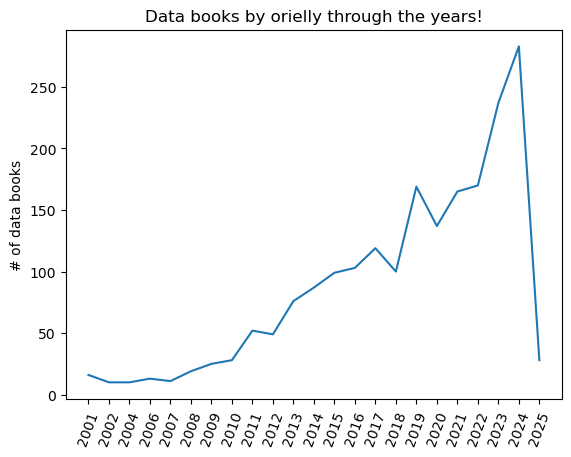

In [36]:
import matplotlib.pyplot as plt
years = sorted(year_counts_filtered)
book_counts = [year_counts_filtered[year] for year in years]
plt.plot(years, book_counts)
plt.ylabel("# of data books")
# xticks to rotate the labels for years
plt.xticks(rotation=70)
plt.title("Data books by orielly through the years!")
plt.show()

In [37]:
x = 0
n = len(year_counts)
for year in  year_counts:
    x+= year_counts[year]

In [41]:
avg_books_per_year = x/n
avg_books_per_year

63.5